In [1]:
import pandas as pd
import sqlite3

# 1. Load CSV into pandas
df = pd.read_csv("data.csv", encoding="latin1")
# Fix dates
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# 2. Create SQLite DB and save table
con = sqlite3.connect("retail.db")
df.to_sql("retail", con, if_exists="replace", index=False)
con.close()


In [2]:
%load_ext isqlite3

%sql_open retail.db 


Done!
Done!


In [3]:
%%sql

SELECT *
FROM retail
LIMIT 5;


InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
%%sql

SELECT COUNT(*) AS rows, 
       SUM(CASE WHEN Quantity>0 AND UnitPrice>0 AND InvoiceNo NOT LIKE 'C%' THEN 1 ELSE 0 END) AS clean_rows
FROM retail;


rows,clean_rows
541909,530104


In [5]:
%%sql

SELECT ROUND(SUM(Quantity * UnitPrice), 2) AS total_revenue
FROM retail
WHERE Quantity > 0 AND UnitPrice > 0 AND InvoiceNo NOT LIKE 'C%';


total_revenue
10666684.54


In [32]:
%%sql
SELECT strftime('%Y-%m', InvoiceDate) AS month,
       ROUND(SUM(Quantity * UnitPrice), 2) AS revenue
FROM retail
WHERE Quantity > 0 AND UnitPrice > 0 AND InvoiceNo NOT LIKE 'C%'
GROUP BY month
ORDER BY revenue DESC;


month,revenue
2011-11,1509496.33
2011-10,1154979.3
2011-09,1058590.17
2010-12,823746.14
2011-05,770536.02
2011-06,761739.9
2011-08,759138.38
2011-07,719221.19
2011-03,717639.36
2011-01,691364.56


In [31]:
%%sql
WITH orders AS (
  SELECT InvoiceNo,
         MIN(InvoiceDate) AS order_ts,
         SUM(Quantity * UnitPrice) AS order_value,
         SUM(Quantity) AS units
  FROM retail
  WHERE Quantity > 0 AND UnitPrice > 0 AND InvoiceNo NOT LIKE 'C%'
  GROUP BY InvoiceNo
)
SELECT strftime('%Y-%m', order_ts) AS month,
       ROUND(AVG(order_value), 2) AS aov,
       ROUND(AVG(units), 2) AS units_per_order
FROM orders
GROUP BY month
ORDER BY aov DESC;


month,aov,units_per_order
2011-12,779.97,383.7
2011-01,636.62,357.08
2011-09,576.26,310.73
2011-10,566.17,305.59
2011-08,557.78,309.9
2011-11,545.14,272.48
2010-12,528.38,230.43
2011-06,496.89,253.89
2011-03,493.56,259.65
2011-07,487.61,272.38


In [8]:
%%sql
SELECT Description,
       ROUND(SUM(Quantity * UnitPrice), 2) AS revenue,
       SUM(Quantity) AS units
FROM retail
WHERE Quantity > 0 AND UnitPrice > 0 AND InvoiceNo NOT LIKE 'C%'
GROUP BY Description
ORDER BY revenue DESC
LIMIT 20;


Description,revenue,units
DOTCOM POSTAGE,206248.77,706
REGENCY CAKESTAND 3 TIER,174484.74,13879
"PAPER CRAFT , LITTLE BIRDIE",168469.6,80995
WHITE HANGING HEART T-LIGHT HOLDER,106292.77,37891
PARTY BUNTING,99504.33,18295
JUMBO BAG RED RETROSPOT,94340.05,48474
MEDIUM CERAMIC TOP STORAGE JAR,81700.92,78033
Manual,78112.82,7225
POSTAGE,78101.88,3150
RABBIT NIGHT LIGHT,66964.99,30788


In [9]:
%%sql
SELECT Description,
       SUM(Quantity) AS units,
       ROUND(SUM(Quantity * UnitPrice), 2) AS revenue
FROM retail
WHERE Quantity > 0 AND UnitPrice > 0 AND InvoiceNo NOT LIKE 'C%'
GROUP BY Description
ORDER BY units DESC
LIMIT 20;


Description,units,revenue
"PAPER CRAFT , LITTLE BIRDIE",80995,168469.6
MEDIUM CERAMIC TOP STORAGE JAR,78033,81700.92
WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047,13841.85
JUMBO BAG RED RETROSPOT,48474,94340.05
WHITE HANGING HEART T-LIGHT HOLDER,37891,106292.77
POPCORN HOLDER,36761,34298.87
ASSORTED COLOUR BIRD ORNAMENT,36461,59094.93
PACK OF 72 RETROSPOT CAKE CASES,36419,21259.1
RABBIT NIGHT LIGHT,30788,66964.99
MINI PAINT SET VINTAGE,26633,16937.82


In [10]:
%%sql
SELECT Country,
       ROUND(SUM(Quantity * UnitPrice), 2) AS revenue,
       COUNT(DISTINCT InvoiceNo) AS orders
FROM retail
WHERE Quantity > 0 AND UnitPrice > 0 AND InvoiceNo NOT LIKE 'C%'
GROUP BY Country
ORDER BY revenue DESC;


Country,revenue,orders
United Kingdom,9025222.08,18019
Netherlands,285446.34,94
EIRE,283453.96,288
Germany,228867.14,457
France,209715.11,392
Australia,138521.31,57
Spain,61577.11,90
Switzerland,57089.9,54
Belgium,41196.34,98
Sweden,38378.33,36


In [11]:
%%sql
CREATE VIEW IF NOT EXISTS v_sales_clean AS
SELECT *
FROM retail
WHERE Quantity > 0 AND UnitPrice > 0 AND InvoiceNo NOT LIKE 'C%';


Done!


In [12]:
%%sql
SELECT strftime('%Y-%m', InvoiceDate) AS month,
       ROUND(SUM(Quantity * UnitPrice), 2) AS revenue
FROM v_sales_clean
GROUP BY month
ORDER BY month;


month,revenue
2010-12,823746.14
2011-01,691364.56
2011-02,523631.89
2011-03,717639.36
2011-04,537808.62
2011-05,770536.02
2011-06,761739.9
2011-07,719221.19
2011-08,759138.38
2011-09,1058590.17


# Part 2

In [13]:
%%sql
WITH first_orders AS (
  SELECT
    CustomerID,
    MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
)
SELECT
  CustomerID,
  strftime('%Y-%m', first_order) AS cohort_month
FROM first_orders
LIMIT 10;



CustomerID,cohort_month
12346.0,2011-01
12347.0,2010-12
12348.0,2010-12
12349.0,2011-11
12350.0,2011-02
12352.0,2011-02
12353.0,2011-05
12354.0,2011-04
12355.0,2011-05
12356.0,2011-01


In [14]:
%%sql
WITH first_orders AS (
  SELECT
    CustomerID,
    MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
),
orders AS (
  SELECT
    r.CustomerID,
    strftime('%Y-%m', f.first_order) AS cohort_month,
    strftime('%Y-%m', r.InvoiceDate) AS order_month
  FROM v_sales_clean r
  JOIN first_orders f USING (CustomerID)
  WHERE r.CustomerID IS NOT NULL
)
SELECT *
FROM orders
LIMIT 10;



CustomerID,cohort_month,order_month
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
17850.0,2010-12,2010-12
13047.0,2010-12,2010-12


In [15]:
%%sql
WITH first_orders AS (
  SELECT
    CustomerID,
    MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
),
orders AS (
  SELECT
    r.CustomerID,
    strftime('%Y-%m', f.first_order) AS cohort_month,
    strftime('%Y-%m', r.InvoiceDate) AS order_month,
    CAST((julianday(r.InvoiceDate) - julianday(f.first_order)) / 30 AS INT) AS month_offset
  FROM v_sales_clean r
  JOIN first_orders f USING (CustomerID)
  WHERE r.CustomerID IS NOT NULL
)
SELECT *
FROM orders
LIMIT 10;


CustomerID,cohort_month,order_month,month_offset
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
17850.0,2010-12,2010-12,0
13047.0,2010-12,2010-12,0


In [16]:
%%sql
WITH first_orders AS (
  SELECT
    CustomerID,
    MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
),
orders AS (
  SELECT
    r.CustomerID,
    strftime('%Y-%m', f.first_order) AS cohort_month,
    CAST((julianday(r.InvoiceDate) - julianday(f.first_order)) / 30 AS INT) AS month_offset
  FROM v_sales_clean r
  JOIN first_orders f USING (CustomerID)
  WHERE r.CustomerID IS NOT NULL
),
base AS (
  SELECT
    cohort_month,
    COUNT(DISTINCT CustomerID) AS cohort_size
  FROM orders
  WHERE month_offset = 0
  GROUP BY cohort_month
)
SELECT
  o.cohort_month,
  o.month_offset,
  COUNT(DISTINCT o.CustomerID) AS active_customers,
  b.cohort_size,
  ROUND(CAST(COUNT(DISTINCT o.CustomerID) AS FLOAT) / b.cohort_size * 100, 2) AS retention_pct
FROM orders o
JOIN base b USING (cohort_month)
WHERE o.month_offset BETWEEN 0 AND 6
GROUP BY o.cohort_month, o.month_offset
ORDER BY o.cohort_month, o.month_offset;


cohort_month,month_offset,active_customers,cohort_size,retention_pct
2010-12,0,885,885,100.0
2010-12,1,324,885,36.61
2010-12,2,307,885,34.69
2010-12,3,339,885,38.31
2010-12,4,304,885,34.35
2010-12,5,338,885,38.19
2010-12,6,325,885,36.72
2011-01,0,417,417,100.0
2011-01,1,103,417,24.7
2011-01,2,116,417,27.82


In [21]:
%%sql
CREATE VIEW IF NOT EXISTS v_cohort_retention AS
WITH first_orders AS (
  SELECT CustomerID, MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
),
orders AS (
  SELECT r.CustomerID,
         strftime('%Y-%m', f.first_order) AS cohort_month,
         CAST((julianday(r.InvoiceDate) - julianday(f.first_order)) / 30 AS INT) AS month_offset
  FROM v_sales_clean r
  JOIN first_orders f USING (CustomerID)
  WHERE r.CustomerID IS NOT NULL
),
base AS (
  SELECT cohort_month, COUNT(DISTINCT CustomerID) AS cohort_size
  FROM orders
  WHERE month_offset = 0
  GROUP BY cohort_month
)
SELECT o.cohort_month,
       o.month_offset,
       COUNT(DISTINCT o.CustomerID) AS active_customers,
       b.cohort_size,
       ROUND(CAST(COUNT(DISTINCT o.CustomerID) AS FLOAT) / b.cohort_size * 100, 2) AS retention_pct
FROM orders o
JOIN base b USING (cohort_month)
WHERE o.month_offset BETWEEN 0 AND 6
GROUP BY o.cohort_month, o.month_offset;


Done!


In [17]:
%%sql
WITH first_orders AS (
  SELECT CustomerID, MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
),
orders AS (
  SELECT r.CustomerID,
         strftime('%Y-%m', f.first_order) AS cohort_month,
         r.InvoiceNo,
         SUM(r.Quantity * r.UnitPrice) AS order_value
  FROM v_sales_clean r
  JOIN first_orders f USING (CustomerID)
  WHERE r.CustomerID IS NOT NULL
  GROUP BY r.CustomerID, r.InvoiceNo
)
SELECT cohort_month,
       ROUND(SUM(order_value),2) AS cohort_revenue,
       COUNT(DISTINCT CustomerID) AS customers,
       ROUND(SUM(order_value) / COUNT(DISTINCT CustomerID),2) AS revenue_per_customer
FROM orders
GROUP BY cohort_month
ORDER BY cohort_revenue DESC;


cohort_month,cohort_revenue,customers,revenue_per_customer
2010-12,4512148.22,885,5098.47
2011-01,1125882.28,417,2699.96
2011-03,643758.94,452,1424.25
2011-02,593876.88,380,1562.83
2011-05,455545.38,284,1604.03
2011-04,326621.03,300,1088.74
2011-06,273455.23,242,1129.98
2011-09,233296.82,299,780.26
2011-10,227369.54,358,635.11
2011-08,196049.05,169,1160.05


# Part 3

In [26]:
%%sql
SELECT
  strftime('%Y-%m', InvoiceDate) AS month,
  SUM(Quantity * UnitPrice) AS revenue
FROM v_sales_clean
GROUP BY month
ORDER BY month;


month,revenue
2010-12,823746.1399999646
2011-01,691364.5600000108
2011-02,523631.8900000278
2011-03,717639.3600000187
2011-04,537808.6210000243
2011-05,770536.0200000107
2011-06,761739.9000000219
2011-07,719221.1910000272
2011-08,759138.3800000148
2011-09,1058590.171999997


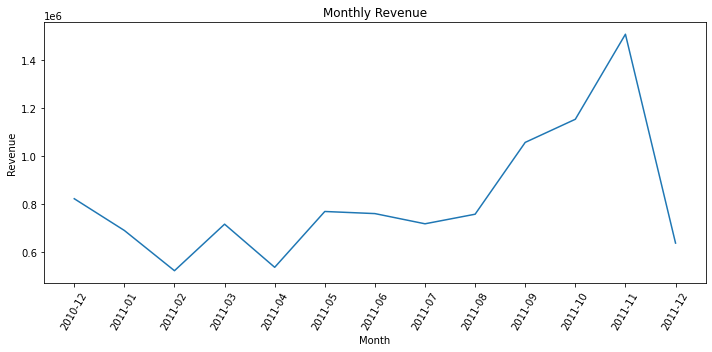

In [23]:
import sqlite3, pandas as pd, matplotlib.pyplot as plt

con = sqlite3.connect("retail.db")
q1 = """
SELECT strftime('%Y-%m', InvoiceDate) AS month,
       SUM(Quantity * UnitPrice) AS revenue
FROM v_sales_clean
GROUP BY month
ORDER BY month;
"""
monthly_rev = pd.read_sql_query(q1, con)

plt.figure(figsize=(10,5))
plt.plot(monthly_rev["month"], monthly_rev["revenue"])
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

monthly_rev.to_csv("monthly_revenue.csv", index=False)


In [27]:
%%sql
SELECT
  Description,
  SUM(Quantity * UnitPrice) AS revenue
FROM v_sales_clean
GROUP BY Description
ORDER BY revenue DESC
LIMIT 10;


Description,revenue
DOTCOM POSTAGE,206248.7700000002
REGENCY CAKESTAND 3 TIER,174484.74000000025
"PAPER CRAFT , LITTLE BIRDIE",168469.6
WHITE HANGING HEART T-LIGHT HOLDER,106292.76999999832
PARTY BUNTING,99504.33000000053
JUMBO BAG RED RETROSPOT,94340.0500000021
MEDIUM CERAMIC TOP STORAGE JAR,81700.92000000007
Manual,78112.81999999993
POSTAGE,78101.87999999999
RABBIT NIGHT LIGHT,66964.99000000028


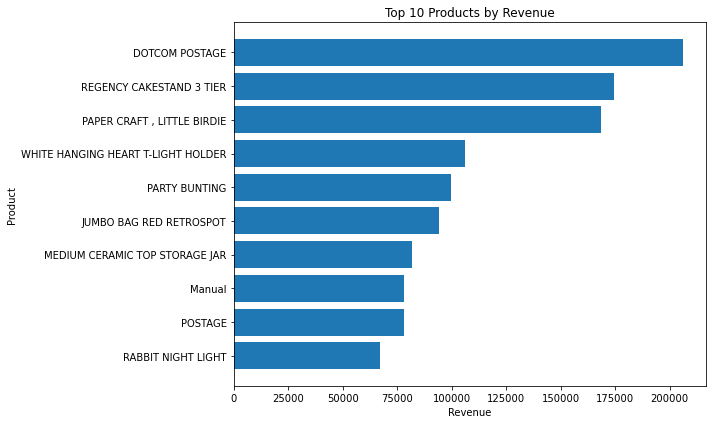

In [28]:
q2 = """
SELECT Description,
       SUM(Quantity * UnitPrice) AS revenue
FROM v_sales_clean
GROUP BY Description
ORDER BY revenue DESC
LIMIT 10;
"""
top_products = pd.read_sql_query(q2, con)

# Plot as horizontal bars, smallest at top for readability
tp = top_products.sort_values("revenue", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(tp["Description"], tp["revenue"])
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

top_products.to_csv("top_products.csv", index=False)


In [29]:
%%sql
WITH first_orders AS (
  SELECT CustomerID, MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
),
orders AS (
  SELECT r.CustomerID,
         strftime('%Y-%m', f.first_order) AS cohort_month,
         CAST((julianday(r.InvoiceDate) - julianday(f.first_order)) / 30 AS INT) AS month_offset
  FROM v_sales_clean r
  JOIN first_orders f USING (CustomerID)
  WHERE r.CustomerID IS NOT NULL
),
base AS (
  SELECT cohort_month, COUNT(DISTINCT CustomerID) AS cohort_size
  FROM orders
  WHERE month_offset = 0
  GROUP BY cohort_month
)
SELECT o.cohort_month,
       o.month_offset,
       ROUND(CAST(COUNT(DISTINCT o.CustomerID) AS FLOAT) / b.cohort_size * 100, 2) AS retention_pct
FROM orders o
JOIN base b USING (cohort_month)
WHERE o.month_offset BETWEEN 0 AND 6
GROUP BY o.cohort_month, o.month_offset
ORDER BY o.cohort_month, o.month_offset;


cohort_month,month_offset,retention_pct
2010-12,0,100.0
2010-12,1,36.61
2010-12,2,34.69
2010-12,3,38.31
2010-12,4,34.35
2010-12,5,38.19
2010-12,6,36.72
2011-01,0,100.0
2011-01,1,24.7
2011-01,2,27.82


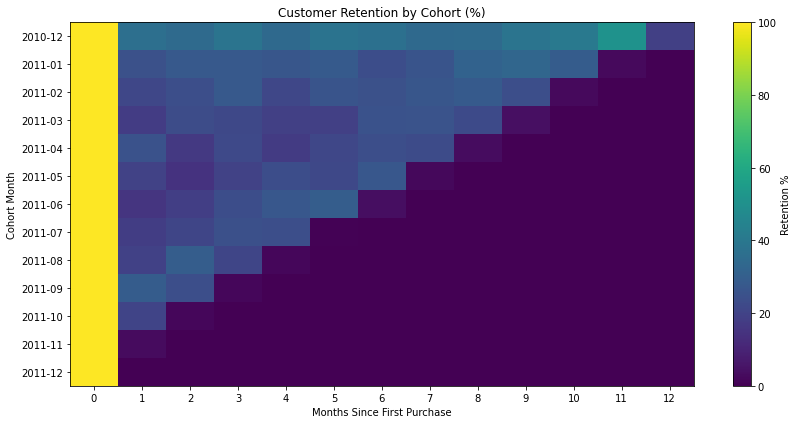

In [30]:
q3 = """
WITH first_orders AS (
  SELECT CustomerID, MIN(InvoiceDate) AS first_order
  FROM v_sales_clean
  WHERE CustomerID IS NOT NULL
  GROUP BY CustomerID
),
orders AS (
  SELECT r.CustomerID,
         strftime('%Y-%m', f.first_order) AS cohort_month,
         CAST((julianday(r.InvoiceDate) - julianday(f.first_order)) / 30 AS INT) AS month_offset
  FROM v_sales_clean r
  JOIN first_orders f USING (CustomerID)
  WHERE r.CustomerID IS NOT NULL
),
base AS (
  SELECT cohort_month, COUNT(DISTINCT CustomerID) AS cohort_size
  FROM orders
  WHERE month_offset = 0
  GROUP BY cohort_month
)
SELECT o.cohort_month,
       o.month_offset,
       ROUND(CAST(COUNT(DISTINCT o.CustomerID) AS FLOAT) / b.cohort_size * 100, 2) AS retention_pct
FROM orders o
JOIN base b USING (cohort_month)
WHERE o.month_offset BETWEEN 0 AND 12
GROUP BY o.cohort_month, o.month_offset
ORDER BY o.cohort_month, o.month_offset;
"""
coh = pd.read_sql_query(q3, con)

# Pivot to matrix form
pivot = coh.pivot(index="cohort_month", columns="month_offset", values="retention_pct").fillna(0)

# Plot heatmap with matplotlib
plt.figure(figsize=(12,6))
im = plt.imshow(pivot.values, aspect="auto")
plt.title("Customer Retention by Cohort (%)")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.colorbar(im, label="Retention %")

# Tick labels
plt.xticks(ticks=range(pivot.shape[1]), labels=pivot.columns.astype(int))
plt.yticks(ticks=range(pivot.shape[0]), labels=pivot.index.tolist())

plt.tight_layout()
plt.show()

pivot.to_csv("cohort_retention_matrix.csv")
